In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Read data

Load eCLIP-seq sequences

In [3]:
eclip = pd.read_csv("HNRNPC/HNRNPC_eclip.txt", sep='\t', header=None)

In [4]:
eclip.head()

,0,1
0,chr7:138151219-138151300,TTTTTTTGGAGACAGCATCTCACTGTGTTGCCCATACTGGAGTGCA...
1,chr7:139051735-139051798,ATTTTTTGGAGACAGAGTCTCTGTCTCCCAGGCGTGAAATGCAGTG...
2,chr7:918222-918272,TTTTTTGCGACGGAGTCTCGCTCTGTCCTCTGTCCCAGGCTGGAGT...
3,chr7:138154088-138154142,TTTTTGAGACAGTGTCTCGTGCAGTGGCCATCTTGGCTCACTGCAA...
4,chr7:138167839-138167908,TTTTTGTAGCGGGGGGGGTCTCACTTTGTTGCCCAGGCTGGTGTCA...


Load RBNS binding affinities

In [5]:
four_mers = pd.read_csv("HNRNPC/HNRNPC_4.tsv", sep='\t')
five_mers = pd.read_csv("HNRNPC/HNRNPC_5.tsv", sep='\t',)
six_mers = pd.read_csv("HNRNPC/HNRNPC_6.tsv", sep='\t',)
four_mers

,[hnRNPC],0,5,20,80,320,1300
0,TTTT,1.050108,1.213564,1.234794,2.755430,11.477239,5.958550
1,ATTT,1.052096,1.124278,0.990108,1.255270,2.505993,1.978384
2,CTTT,1.094396,1.111101,1.087047,1.272162,2.264619,1.867528
3,TTTA,1.023649,1.074103,0.975594,1.183402,2.129294,1.799562
4,TTTC,1.097361,1.150883,1.052075,1.217492,1.999443,1.715131
...,...,...,...,...,...,...,...
251,TCGG,0.830022,0.846412,0.842917,0.818757,0.693297,0.672110
252,TCGT,0.849285,0.844630,0.870984,0.837076,0.685304,0.681841
253,CGTC,0.845628,0.842135,0.878028,0.833263,0.678240,0.691214
254,ATCG,0.849546,0.843249,0.866847,0.828345,0.666320,0.674459


Load knockdown differential rna-seq data

In [6]:
diff_exp_HNRNPC = pd.read_csv("HNRNPC/HNRNPC.tsv", sep='\t',)

In [7]:
diff_exp_HNRNPC.head()

,test_id,gene_id,gene,locus,sample_1,sample_2,status,value_1,value_2,log2(fold_change),test_stat,p_value,q_value,significant
0,XLOC_000001,XLOC_000001,DDX11L1,chr1:11868-31109,HNRNPC-BGHLV20-HepG2,Control,NOTEST,0.000000,0.021689,inf,0.0,1.0,1.0,no
1,XLOC_000002,XLOC_000002,MIR1302-11,chr1:11868-31109,HNRNPC-BGHLV20-HepG2,Control,NOTEST,0.017697,0.000000,-inf,0.0,1.0,1.0,no
2,XLOC_000003,XLOC_000003,OR4G4P,chr1:52472-54936,HNRNPC-BGHLV20-HepG2,Control,NOTEST,0.000000,0.000000,0.0,0.0,1.0,1.0,no
3,XLOC_000004,XLOC_000004,OR4G11P,chr1:62947-63887,HNRNPC-BGHLV20-HepG2,Control,NOTEST,0.000000,0.000000,0.0,0.0,1.0,1.0,no
4,XLOC_000005,XLOC_000005,OR4F5,chr1:69090-70008,HNRNPC-BGHLV20-HepG2,Control,NOTEST,0.000000,0.000000,0.0,0.0,1.0,1.0,no


In [8]:
# get other diff expr for subsetting to shared genes later
diff_exp_SRSF9 = pd.read_csv("SRSF9/SRSF9.tsv", sep='\t',)
diff_exp_PCBP1 = pd.read_csv("PCBP1/PCBP1.tsv", sep='\t',)
diff_exp_TIA1 = pd.read_csv("TIA1/TIA1.tsv", sep='\t',)
diff_exp_TRA2A = pd.read_csv("TRA2A/TRA2A.tsv", sep='\t',)

## QC

In [9]:
def levenshtein(s1, s2):
    n, m = len(s1), len(s2)

    if n == 0:
        return m
    if m == 0:
        return n

    dp = [[0] * (m + 1) for _ in range(n + 1)]

    for i in range(n + 1):
        dp[i][0] = i
    for j in range(m + 1):
        dp[0][j] = j

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = 0 if s1[i-1] == s2[j-1] else 1

            dp[i][j] = min(
                dp[i-1][j] + 1,
                dp[i][j-1] + 1,
                dp[i-1][j-1] + cost
            )

    return dp[n][m]


In [10]:
import itertools

def compute_pairwise_hamming(sequences):
    distances = []
    pairs = []
    for (i, s1), (j, s2) in itertools.combinations(enumerate(sequences), 2):
        d = levenshtein(s1, s2)
        distances.append(d)
        pairs.append((i, j, d))
    return distances, pairs

Check for sequence similarities in eCLIP positive

In [11]:
in_vivo_pos_seqs = eclip[1].values
in_vivo_pos_seqs = [s for s in in_vivo_pos_seqs if len(s) >= 10]
in_vivo_pos_seqs = list(set(in_vivo_pos_seqs))
len(in_vivo_pos_seqs)

627369

Computing distances
Computing close pairs


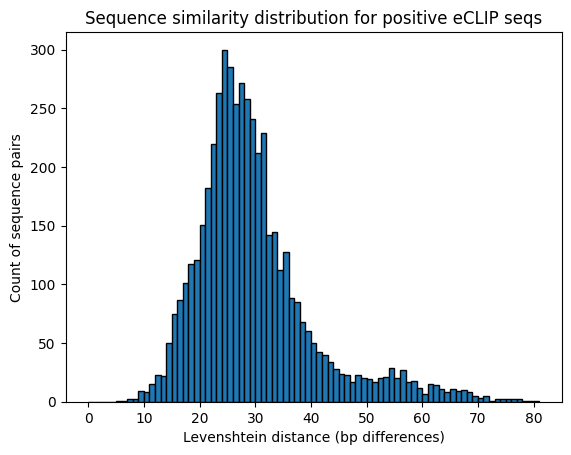

In [12]:
import random
sample_size = 100
sample_seqs = random.sample(in_vivo_pos_seqs, sample_size)
print("Computing distances")
distances, pairs = compute_pairwise_hamming(sample_seqs)
print("Computing close pairs")
close_pairs = [(i, j, d) for (i, j, d) in pairs if d <= 2]
for i, j, d in close_pairs:
    print(f"Seq {i} and Seq {j} differ by {d} bp")
    
plt.hist(distances, bins=range(0, max(distances)+2), edgecolor='black')
plt.xlabel("Levenshtein distance (bp differences)")
plt.ylabel("Count of sequence pairs")
plt.title("Sequence similarity distribution for positive eCLIP seqs")
plt.show()

Check for sequence similarities in eCLIP negative

In [13]:
import random
def shuffle_by_pairs(seq):
    pairs = [seq[i:i+2] for i in range(0, len(seq), 2)]
    random.shuffle(pairs)
    return "".join(pairs)
in_vivo_neg_seqs = [shuffle_by_pairs(seq) for seq in eclip[1].values]
# filter for length and unique values
in_vivo_neg_seqs = [s for s in in_vivo_neg_seqs if len(s) >= 10]
in_vivo_neg_seqs = list(set(in_vivo_neg_seqs))
len(in_vivo_neg_seqs)

627721

Computing distances
Computing close pairs


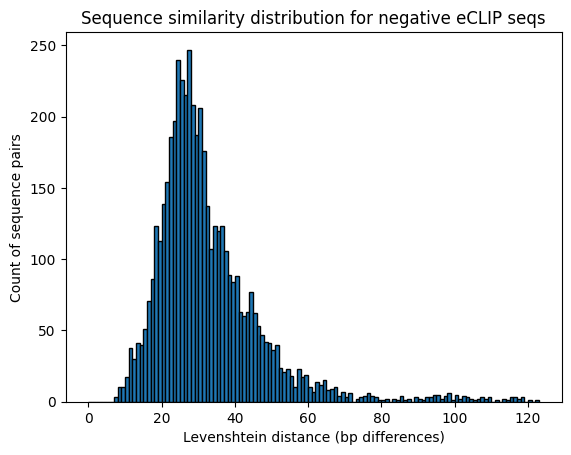

In [14]:
import random
sample_size = 100
sample_seqs = random.sample(in_vivo_neg_seqs, sample_size)
print("Computing distances")
distances, pairs = compute_pairwise_hamming(sample_seqs)
print("Computing close pairs")
close_pairs = [(i, j, d) for (i, j, d) in pairs if d <= 2]
    
plt.hist(distances, bins=range(0, max(distances)+2), edgecolor='black')
plt.xlabel("Levenshtein distance (bp differences)")
plt.ylabel("Count of sequence pairs")
plt.title("Sequence similarity distribution for negative eCLIP seqs")
plt.show()

Check for sequence similarities in RBNS positive

In [15]:
def get_signficant_sequences(df):
    num_cols = df.columns[1:]
    filtered = df[df[num_cols].gt(2).any(axis=1)]
    pairs = [
        (row[df.columns[0]], tuple(row[num_cols]))
        for _, row in filtered.iterrows()
    ]
    return pairs

In [16]:
pos_four_mers = get_signficant_sequences(four_mers)
pos_five_mers = get_signficant_sequences(five_mers)
pos_six_mers = get_signficant_sequences(six_mers)
in_vitro_pos_seqs = np.concatenate((pos_four_mers,pos_five_mers,pos_six_mers))
in_vitro_pos_seqs = [x for (x,y) in in_vitro_pos_seqs]

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Computing distances
Computing close pairs


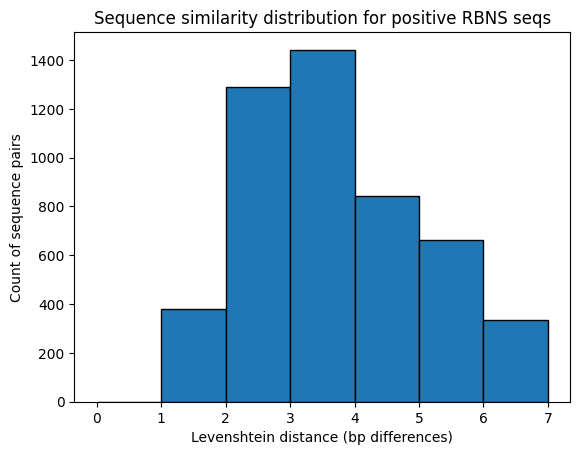

In [17]:
import random
sample_size = 100
sample_seqs = random.sample(in_vitro_pos_seqs, sample_size)
print("Computing distances")
distances, pairs = compute_pairwise_hamming(sample_seqs)
print("Computing close pairs")
close_pairs = [(i, j, d) for (i, j, d) in pairs if d <= 2]
    
plt.hist(distances, bins=range(0, max(distances)+2), edgecolor='black')
plt.xlabel("Levenshtein distance (bp differences)")
plt.ylabel("Count of sequence pairs")
plt.title("Sequence similarity distribution for positive RBNS seqs")
plt.show()

Check for sequence similarities in RBNS negative

In [18]:
def get_insignficant_sequences(df):
    num_cols = df.columns[1:]
    filtered = df[df[num_cols].lt(2).any(axis=1)]
    pairs = [
        (row[df.columns[0]], tuple(row[num_cols]))
        for _, row in filtered.iterrows()
    ]
    return pairs

In [19]:
neg_four_mers = get_insignficant_sequences(four_mers)
neg_five_mers = get_insignficant_sequences(five_mers)
neg_six_mers = get_insignficant_sequences(six_mers)
in_vitro_neg_seqs = np.concatenate((neg_four_mers,neg_five_mers,neg_six_mers))
in_vitro_neg_seqs = [x for (x,y) in in_vitro_neg_seqs]

Computing distances
Computing close pairs


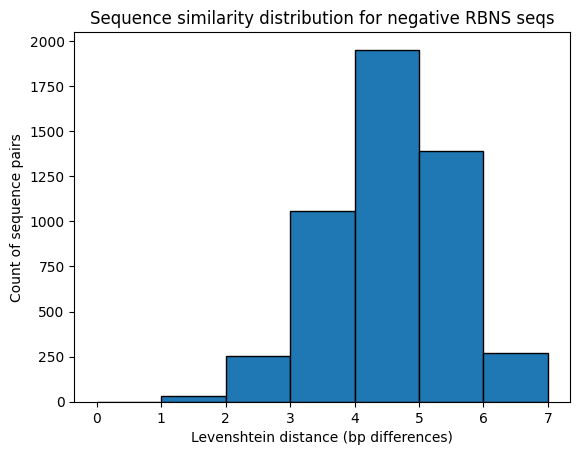

In [20]:
import random
sample_size = 100
sample_seqs = random.sample(in_vitro_neg_seqs, sample_size)
print("Computing distances")
distances, pairs = compute_pairwise_hamming(sample_seqs)
print("Computing close pairs")
close_pairs = [(i, j, d) for (i, j, d) in pairs if d <= 2]
    
plt.hist(distances, bins=range(0, max(distances)+2), edgecolor='black')
plt.xlabel("Levenshtein distance (bp differences)")
plt.ylabel("Count of sequence pairs")
plt.title("Sequence similarity distribution for negative RBNS seqs")
plt.show()

## Generate positive pairs

EClip positive binding sites

In [9]:
in_vivo_pos_seqs = eclip[1].values

In [10]:
# filter for length and unique values
in_vivo_pos_seqs = [s for s in in_vivo_pos_seqs if len(s) >= 10]
in_vivo_pos_seqs = list(set(in_vivo_pos_seqs))

RBNS significant binding affinity

In [11]:
def get_signficant_sequences(df):
    num_cols = df.columns[1:]
    filtered = df[df[num_cols].gt(2).any(axis=1)]
    pairs = [
        (row[df.columns[0]], tuple(row[num_cols]))
        for _, row in filtered.iterrows()
    ]
    return pairs

In [12]:
pos_four_mers = get_signficant_sequences(four_mers)
pos_five_mers = get_signficant_sequences(five_mers)
pos_six_mers = get_signficant_sequences(six_mers)

In [13]:
pos_six_mers

[('TTTTTT', (1.071962, 1.692866, 3.672444, 17.832708, 94.802148, 35.212764)),
 ('ATTTTT', (1.076105, 1.348466, 1.481458, 3.968517, 19.883022, 10.642442)),
 ('CTTTTT', (1.067404, 1.24024, 1.319701, 3.161729, 14.967689, 8.264041)),
 ('TTTTTA', (1.023226, 1.254425, 1.27889, 2.985524, 14.87552, 8.87071)),
 ('TTTTTC', (1.121678, 1.305399, 1.288073, 2.738826, 12.616572, 7.35691)),
 ('TATTTT', (1.023793, 1.20788, 1.17275, 2.489906, 10.644826, 6.290213)),
 ('TTTTTG', (0.996192, 1.196576, 1.128267, 2.251156, 9.510792, 5.751316)),
 ('GTTTTT', (1.00087, 1.27983, 1.1027, 2.268313, 9.301687, 5.271012)),
 ('TTTTAT', (1.046737, 1.178148, 1.108257, 1.996217, 7.586432, 4.897009)),
 ('TCTTTT', (1.089925, 1.15815, 1.188027, 1.980937, 6.885662, 4.33642)),
 ('AATTTT', (1.123924, 1.302106, 1.129826, 1.970238, 6.694241, 4.646509)),
 ('CATTTT', (1.046779, 1.159885, 1.076534, 1.901975, 6.610391, 4.293748)),
 ('TTTTCT', (1.13576, 1.25046, 1.147984, 1.876544, 6.591292, 4.298317)),
 ('TTATTT', (1.053787, 1.141478

In [14]:
in_vitro_pos_seqs = np.concatenate((pos_four_mers,pos_five_mers,pos_six_mers))
in_vitro_pos_seqs.shape

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(117, 2)

In [15]:
unique_rbns = {}
for s, arr in in_vitro_pos_seqs:
    if s not in unique_rbns:
        unique_rbns[s] = arr

in_vitro_pos_seqs = list(unique_rbns.items())
len(in_vitro_pos_seqs)

117

Filter diff expr

In [16]:
# remove when gene expression is always 0 or if logfold change is inf/-inf
diff_exp_filtered_HNRNPC = diff_exp_HNRNPC[
    ~(
        ((diff_exp_HNRNPC["value_1"] == 0) & (diff_exp_HNRNPC["value_2"] == 0)) |
        (diff_exp_HNRNPC["log2(fold_change)"].isin([np.inf, -np.inf]))
    )
]

diff_exp_filtered_SRSF9 = diff_exp_SRSF9[
    ~(
        ((diff_exp_SRSF9["value_1"] == 0) & (diff_exp_SRSF9["value_2"] == 0)) |
        (diff_exp_SRSF9["log2(fold_change)"].isin([np.inf, -np.inf]))
    )
]

diff_exp_filtered_PCBP1 = diff_exp_PCBP1[
    ~(
        ((diff_exp_PCBP1["value_1"] == 0) & (diff_exp_PCBP1["value_2"] == 0)) |
        (diff_exp_PCBP1["log2(fold_change)"].isin([np.inf, -np.inf]))
    )
]

diff_exp_filtered_TIA1 = diff_exp_TIA1[
    ~(
        ((diff_exp_TIA1["value_1"] == 0) & (diff_exp_TIA1["value_2"] == 0)) |
        (diff_exp_TIA1["log2(fold_change)"].isin([np.inf, -np.inf]))
    )
]

diff_exp_filtered_TRA2A = diff_exp_TRA2A[
    ~(
        ((diff_exp_TRA2A["value_1"] == 0) & (diff_exp_TRA2A["value_2"] == 0)) |
        (diff_exp_TRA2A["log2(fold_change)"].isin([np.inf, -np.inf]))
    )
]

In [17]:
dfs = [diff_exp_filtered_HNRNPC, diff_exp_filtered_SRSF9, diff_exp_filtered_PCBP1, diff_exp_filtered_TIA1, diff_exp_filtered_TRA2A]
col = "gene_id"
shared_keys = set.intersection(*(set(df[col]) for df in dfs))

# 2. Subset the dataframe you want (example: df1)
diff_exp_filtered_HNRNPC = diff_exp_filtered_HNRNPC[diff_exp_filtered_HNRNPC[col].isin(shared_keys)]

In [18]:
diff_exp_filtered_HNRNPC.head()

,test_id,gene_id,gene,locus,sample_1,sample_2,status,value_1,value_2,log2(fold_change),test_stat,p_value,q_value,significant
7,XLOC_000008,XLOC_000008,OR4F29,chr1:317719-461954,HNRNPC-BGHLV20-HepG2,Control,OK,0.42339,1.53871,1.861660,0.889161,0.00805,0.035235,yes
11,XLOC_000012,XLOC_000012,MTND1P23,chr1:536815-660283,HNRNPC-BGHLV20-HepG2,Control,OK,410.13200,336.58000,-0.285138,-0.149730,0.81500,0.897404,no
12,XLOC_000013,XLOC_000013,MTND2P28,chr1:536815-660283,HNRNPC-BGHLV20-HepG2,Control,OK,931.02300,834.29300,-0.158262,-0.292230,0.66870,0.802839,no
13,XLOC_000014,XLOC_000014,hsa-mir-6723,chr1:536815-660283,HNRNPC-BGHLV20-HepG2,Control,OK,1147.94000,1761.41000,0.617688,1.819070,0.00955,0.040072,yes
14,XLOC_000015,XLOC_000015,RP5-857K21.7,chr1:536815-660283,HNRNPC-BGHLV20-HepG2,Control,OK,1200.71000,1284.82000,0.097686,0.164563,0.81710,0.898417,no


In [19]:
diff_exp_filtered_HNRNPC.shape

(17985, 14)

In [20]:
logfold_changes = diff_exp_filtered_HNRNPC['log2(fold_change)'].values
logfold_changes

array([ 1.86166 , -0.285138, -0.158262, ..., -1.65698 ,  0.128098,
       -1.54899 ])

## Generate negative pairs

Shuffle eCLIP sequences

In [49]:
import random
def shuffle_by_pairs(seq):
    pairs = [seq[i:i+2] for i in range(0, len(seq), 2)]
    random.shuffle(pairs)
    return "".join(pairs)
in_vivo_neg_seqs = [shuffle_by_pairs(seq) for seq in eclip[1].values]
len(in_vivo_neg_seqs)

647011

In [50]:
# filter for length and unique values
in_vivo_neg_seqs = [s for s in in_vivo_neg_seqs if len(s) >= 10]
in_vivo_neg_seqs = list(set(in_vivo_neg_seqs))
in_vivo_neg_seqs = list(set(in_vivo_neg_seqs) - set(in_vivo_pos_seqs))
len(in_vivo_neg_seqs)

627547

Retrieve RBNS sequences that are not enriched

In [54]:
def get_insignficant_sequences(df):
    num_cols = df.columns[1:]
    filtered = df[df[num_cols].lt(2).any(axis=1)]
    pairs = [
        (row[df.columns[0]], tuple(row[num_cols]))
        for _, row in filtered.iterrows()
    ]
    return pairs

In [55]:
neg_four_mers = get_insignficant_sequences(four_mers)
neg_five_mers = get_insignficant_sequences(five_mers)
neg_six_mers = get_insignficant_sequences(six_mers)

In [56]:
neg_four_mers

[('TTTT', (1.050108, 1.213564, 1.234794, 2.75543, 11.477239, 5.95855)),
 ('ATTT', (1.052096, 1.124278, 0.990108, 1.25527, 2.505993, 1.978384)),
 ('CTTT', (1.094396, 1.111101, 1.087047, 1.272162, 2.264619, 1.867528)),
 ('TTTA', (1.023649, 1.074103, 0.975594, 1.183402, 2.129294, 1.799562)),
 ('TTTC', (1.097361, 1.150883, 1.052075, 1.217492, 1.999443, 1.715131)),
 ('TATT', (1.039198, 1.06593, 1.000795, 1.150161, 1.713124, 1.496541)),
 ('TTTG', (1.004893, 1.050304, 0.987782, 1.093798, 1.596789, 1.390267)),
 ('GTTT', (0.973983, 1.046386, 0.956951, 1.079698, 1.564893, 1.351425)),
 ('CCCC', (1.419824, 1.45442, 1.343596, 1.41312, 1.549043, 1.601944)),
 ('TTAT', (1.011911, 1.034474, 0.975124, 1.09913, 1.524726, 1.373946)),
 ('ACCC', (1.48522, 1.480864, 1.389412, 1.432278, 1.504673, 1.613837)),
 ('TTCT', (1.115392, 1.128724, 1.087663, 1.167728, 1.499969, 1.362751)),
 ('CACC', (1.425643, 1.40017, 1.396304, 1.407528, 1.478731, 1.612886)),
 ('TCTT', (1.067138, 1.066816, 1.070433, 1.137513, 1.47739,

In [58]:
in_vitro_neg_seqs_all = np.concatenate((neg_four_mers,neg_five_mers,neg_six_mers))
pos_rbns_seqs = {s for s, _ in in_vitro_pos_seqs}
in_vitro_neg_seqs = np.array([(s, v) for s, v in in_vitro_neg_seqs_all if s not in pos_rbns_seqs])
in_vitro_neg_seqs.shape

/tmp/ipykernel_2904986/4178471540.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  in_vitro_neg_seqs = np.array([(s, v) for s, v in in_vitro_neg_seqs_all if s not in pos_rbns_seqs])


(5259, 2)

In [59]:
unique_rbns = {}
for s, arr in in_vitro_neg_seqs:
    if s not in unique_rbns:
        unique_rbns[s] = arr

in_vitro_neg_seqs = list(unique_rbns.items())
len(in_vitro_neg_seqs)

5259

Construct placeholder expression change vector

In [60]:
placeholder_logfold_changes = np.zeros(shape=logfold_changes.shape)

## Split into train/val/test

In [61]:
# number of total samples per class
combinations_size = 500000

Positive samples

In [62]:
from itertools import product

random.shuffle(in_vivo_pos_seqs)
random.shuffle(in_vitro_pos_seqs)

n_eclip = len(in_vivo_pos_seqs)
n_rbns  = len(in_vitro_pos_seqs)

# Split indices
train_eclip = in_vivo_pos_seqs[:int(0.7*n_eclip)]
val_eclip   = in_vivo_pos_seqs[int(0.7*n_eclip):int(0.85*n_eclip)]
test_eclip  = in_vivo_pos_seqs[int(0.85*n_eclip):]

train_rbns = in_vitro_pos_seqs[:int(0.7*n_rbns)]
val_rbns   = in_vitro_pos_seqs[int(0.7*n_rbns):int(0.85*n_rbns)]
test_rbns  = in_vitro_pos_seqs[int(0.85*n_rbns):]

pos_train_samples = [
    (random.choice(train_eclip), random.choice(train_rbns))
    for _ in range(combinations_size)
]
pos_val_samples = [
    (random.choice(val_eclip), random.choice(val_rbns))
    for _ in range(combinations_size)
]
pos_test_samples = [
    (random.choice(test_eclip), random.choice(test_rbns))
    for _ in range(combinations_size)
]

In [65]:
pos_train_eclips = set(eclip for eclip, _ in pos_train_samples)
pos_val_eclips   = set(eclip for eclip, _ in pos_val_samples)
pos_test_eclips  = set(eclip for eclip, _ in pos_test_samples)

assert pos_train_eclips.isdisjoint(pos_val_eclips), "Overlap between train and val eCLIP sequences!"
assert pos_train_eclips.isdisjoint(pos_test_eclips), "Overlap between train and test eCLIP sequences!"
assert pos_val_eclips.isdisjoint(pos_test_eclips), "Overlap between val and test eCLIP sequences!"
print("eCLIP sequences are disjoint across splits")

eCLIP sequences are disjoint across splits


In [66]:
pos_train_rbns = set(rbns for _, (rbns, _) in pos_train_samples)
pos_val_rbns   = set(rbns for _, (rbns, _) in pos_val_samples)
pos_test_rbns  = set(rbns for _, (rbns, _) in pos_test_samples)

assert pos_train_rbns.isdisjoint(val_rbns), "Overlap between train and val RBNS sequences!"
assert pos_val_rbns.isdisjoint(test_rbns), "Overlap between train and test RBNS sequences!"
assert pos_test_rbns.isdisjoint(test_rbns), "Overlap between val and test RBNS sequences!"
print("RBNS sequences are disjoint across splits")

RBNS sequences are disjoint across splits


In [67]:
pos_train_label = np.ones(len(pos_train_samples))
pos_val_label = np.ones(len(pos_val_samples))
pos_test_label = np.ones(len(pos_test_samples))

Negative samples

In [68]:
random.shuffle(in_vivo_neg_seqs)
random.shuffle(in_vitro_neg_seqs)

n_eclip = len(in_vivo_neg_seqs)
n_rbns  = len(in_vitro_neg_seqs)

# Split indices
train_eclip = in_vivo_neg_seqs[:int(0.7*n_eclip)]
val_eclip   = in_vivo_neg_seqs[int(0.7*n_eclip):int(0.85*n_eclip)]
test_eclip  = in_vivo_neg_seqs[int(0.85*n_eclip):]

train_rbns = in_vitro_neg_seqs[:int(0.7*n_rbns)]
val_rbns   = in_vitro_neg_seqs[int(0.7*n_rbns):int(0.85*n_rbns)]
test_rbns  = in_vitro_neg_seqs[int(0.85*n_rbns):]

neg_train_samples = [
    (random.choice(train_eclip), random.choice(train_rbns))
    for _ in range(combinations_size)
]
neg_val_samples = [
    (random.choice(val_eclip), random.choice(val_rbns))
    for _ in range(combinations_size)
]
neg_test_samples = [
    (random.choice(test_eclip), random.choice(test_rbns))
    for _ in range(combinations_size)
]

In [69]:
neg_train_label = np.zeros(len(neg_train_samples))
neg_val_label = np.zeros(len(neg_val_samples))
neg_test_label = np.zeros(len(neg_test_samples))

In [70]:
train_eclips = set(eclip for eclip, _ in neg_train_samples)
val_eclips   = set(eclip for eclip, _ in neg_val_samples)
test_eclips  = set(eclip for eclip, _ in neg_test_samples)

assert train_eclips.isdisjoint(val_eclips), "Overlap between train and val eCLIP sequences!"
assert train_eclips.isdisjoint(test_eclips), "Overlap between train and test eCLIP sequences!"
assert val_eclips.isdisjoint(test_eclips), "Overlap between val and test eCLIP sequences!"
print("eCLIP sequences are disjoint across splits")

eCLIP sequences are disjoint across splits


In [71]:
train_rbns = set(rbns for _, (rbns, _) in neg_train_samples)
val_rbns   = set(rbns for _, (rbns, _) in neg_val_samples)
test_rbns  = set(rbns for _, (rbns, _) in neg_test_samples)

assert train_rbns.isdisjoint(val_rbns), "Overlap between train and val RBNS sequences!"
assert train_rbns.isdisjoint(test_rbns), "Overlap between train and test RBNS sequences!"
assert val_rbns.isdisjoint(test_rbns), "Overlap between val and test RBNS sequences!"
print("RBNS sequences are disjoint across splits")

RBNS sequences are disjoint across splits


In [72]:
# check across pos and neg samples
assert train_eclips.isdisjoint(pos_train_eclips), "Overlap between train and val eCLIP sequences!"
assert val_eclips.isdisjoint(pos_val_eclips), "Overlap between train and test eCLIP sequences!"
assert test_eclips.isdisjoint(pos_test_eclips), "Overlap between val and test eCLIP sequences!"

In [73]:
assert train_rbns.isdisjoint(pos_train_rbns), "Overlap between train and val RBNS sequences!"
assert val_rbns.isdisjoint(pos_val_rbns), "Overlap between train and test RBNS sequences!"
assert test_rbns.isdisjoint(pos_test_rbns), "Overlap between val and test RBNS sequences!"

Combine for full splits

In [74]:
train_data = np.concatenate((pos_train_samples, neg_train_samples))
val_data = np.concatenate((pos_val_samples, neg_val_samples))
test_data = np.concatenate((pos_test_samples, neg_test_samples))

train_labels = np.concatenate((pos_train_label, neg_train_label))
val_labels = np.concatenate((pos_val_label, neg_val_label))
test_labels = np.concatenate((pos_test_label, neg_test_label))

In [75]:
# get positive/negative label values
positive_value = ("HNRNPC", logfold_changes)
negative_value = ("Not HNRNPC", placeholder_logfold_changes)

## Save as dictionaries

Save as pickle files since there are nested data structures

In [76]:
import pickle

In [77]:
'''
Saved data format for each split:
- Input
    - List containing:
        - eCLIP sequence: text
        - Tuple of RBNS sequence and binding affinity: (text, vector)
        
Labels save separately to save storage:
- List containing:
    - RBP label: text
    - Logfold gene expression change: vector
'''

'\nSaved data format for each split:\n- Input\n    - List containing:\n        - eCLIP sequence: text\n        - Tuple of RBNS sequence and binding affinity: (text, vector)\n- Output\n    - List containing:\n        - RBP label: text\n        - Logfold gene expression change: vector\n        \nLabels save separately to save storage:\n- List containing:\n    - RBP label: text\n    - Logfold gene expression change: vector\n'

In [78]:
# Save train
with open("HNRNPC/train_split.pkl", "wb") as f:
    pickle.dump((train_data, train_labels), f)

In [79]:
# Save val
with open("HNRNPC/val_split.pkl", "wb") as f:
    pickle.dump((val_data, val_labels), f)

In [80]:
# Save test
with open("HNRNPC/test_split.pkl", "wb") as f:
    pickle.dump((test_data, test_labels), f)

In [81]:
# Save positive label
with open("HNRNPC/HNRNPC_positive_label.pkl", "wb") as f:
    pickle.dump(positive_value, f)

In [82]:
# Save negative label
with open("HNRNPC/HNRNPC_negative_label.pkl", "wb") as f:
    pickle.dump(negative_value, f)